In [1]:
%pip install torch torchvision opencv-python matplotlib seaborn tqdm scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [3]:
import os
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, folder, label, transform=None, seq_len=10):
        self.transform = transform
        self.seq_len = seq_len
        self.label = label
        self.samples = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".mp4")]

    def __len__(self):
        return len(self.samples)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (64, 64))
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        if len(frames) < self.seq_len:
            return None
        idxs = np.linspace(0, len(frames) - 1, self.seq_len).astype(int)
        return torch.stack([frames[i] for i in idxs])

    def __getitem__(self, idx):
        path = self.samples[idx]
        frames = self.read_video(path)
        while frames is None:
            idx = (idx + 1) % len(self.samples)
            path = self.samples[idx]
            frames = self.read_video(path)
        return frames, torch.tensor(self.label, dtype=torch.long)


In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

base = r"C:\Users\julliana rose\Documents\4th Year\Capstone\BEA\Fidgeting\tapping_feet_v3"

train_data = [
    VideoDataset(os.path.join(base, "tapping/training"), 1, transform),
    VideoDataset(os.path.join(base, "non-tapping/training"), 0, transform)
]

test_data = [
    VideoDataset(os.path.join(base, "tapping/testing"), 1, transform),
    VideoDataset(os.path.join(base, "non-tapping/testing"), 0, transform)
]

train_dataset = ConcatDataset(train_data)
test_dataset = ConcatDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")


Train: 520 | Test: 128


In [5]:
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")


c:\Users\julliana rose\Documents\4th Year\Capstone\BEA\Fidgeting\tapping_feet_v3\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\julliana rose\Documents\4th Year\Capstone\BEA\Fidgeting\tapping_feet_v3\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 130/130 [02:12<00:00,  1.02s/it]


Epoch 1/10 | Loss: 72.4671


100%|██████████| 130/130 [02:04<00:00,  1.05it/s]


Epoch 2/10 | Loss: 40.4170


100%|██████████| 130/130 [02:08<00:00,  1.01it/s]


Epoch 3/10 | Loss: 25.3649


100%|██████████| 130/130 [02:08<00:00,  1.01it/s]


Epoch 4/10 | Loss: 22.1574


100%|██████████| 130/130 [02:08<00:00,  1.01it/s]


Epoch 5/10 | Loss: 16.4374


100%|██████████| 130/130 [02:07<00:00,  1.02it/s]


Epoch 6/10 | Loss: 22.8835


100%|██████████| 130/130 [02:06<00:00,  1.02it/s]


Epoch 7/10 | Loss: 13.5571


100%|██████████| 130/130 [02:05<00:00,  1.04it/s]


Epoch 8/10 | Loss: 13.9166


100%|██████████| 130/130 [02:00<00:00,  1.08it/s]


Epoch 9/10 | Loss: 15.7197


100%|██████████| 130/130 [02:13<00:00,  1.02s/it]

Epoch 10/10 | Loss: 18.0887



Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

 Non-Tapping       1.00      0.97      0.98        64
     Tapping       0.97      1.00      0.98        64

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



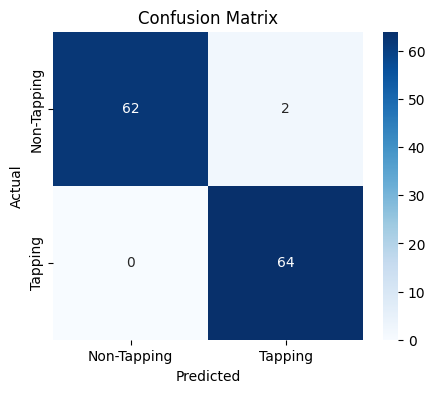

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {acc:.2f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Tapping", "Tapping"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Tapping", "Tapping"], yticklabels=["Non-Tapping", "Tapping"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [8]:
torch.save(model.state_dict(), "tapping_feet_mobilenet4.pth")
print("Model saved as tapping_feet_mobilenet4.pth")

Model saved as tapping_feet_mobilenet4.pth


In [9]:
pip install torch torchvision opencv-python mediapipe pillow pygame

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [24]:
# Testing w/ Skeleton and Tap Count Only (No Time, No ADHD Likelihood)
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import time
import mediapipe as mp

# --- Model Definition ---
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

# --- Setup ---
SEQ_FRAMES = 10
IMG_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNLSTM().to(device)
model.load_state_dict(torch.load("tapping_feet_mobilenet2.pth", map_location=device))
model.eval()

mp_pose = mp.solutions.pose
pose_tracker = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

class TapCounterApp:
    def __init__(self, root):
        self.root = root
        self.root.title("BEA - Total Tap Counter")

        self.canvas = tk.Label(root)
        self.canvas.pack()

        self.count_label = tk.Label(root, text="Total Taps: 0", font=("Arial", 18))
        self.count_label.pack(pady=5)

        self.cap = cv2.VideoCapture(1)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        self.frame_queue = deque(maxlen=SEQ_FRAMES)
        self.tap_count = 0
        self.last_tap_time = time.time()
        self.min_interval = 0.3
        self.prev_gray = None

        self.update_frame()

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            self.root.after(10, self.update_frame)
            return

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_img = cv2.resize(rgb, (640, 480))
        model_input_frame = display_img.copy()

        pose_results = pose_tracker.process(display_img)
        pose_valid = False

        if pose_results.pose_landmarks:
            h, w, _ = display_img.shape
            lm = pose_results.pose_landmarks.landmark
            required_landmarks = [
                mp_pose.PoseLandmark.LEFT_KNEE,
                mp_pose.PoseLandmark.LEFT_ANKLE,
                mp_pose.PoseLandmark.RIGHT_KNEE,
                mp_pose.PoseLandmark.RIGHT_ANKLE
            ]
            pose_valid = all(lm[i].visibility > 0.5 for i in required_landmarks)

            # --- Draw Skeleton for Leg Landmarks ---
            def get_coord(index):
                point = lm[index]
                return int(point.x * w), int(point.y * h)

            LEG_PAIRS = [
                (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
                (mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_HEEL),
                (mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.LEFT_FOOT_INDEX),
                (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE),
                (mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_HEEL),
                (mp_pose.PoseLandmark.RIGHT_HEEL, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            ]

            for start, end in LEG_PAIRS:
                x1, y1 = get_coord(start)
                x2, y2 = get_coord(end)
                cv2.line(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(display_img, (x1, y1), 6, (0, 255, 0), -1)
                cv2.circle(display_img, (x2, y2), 6, (0, 255, 0), -1)

        # --- Motion Detection ---
        gray = cv2.cvtColor(model_input_frame, cv2.COLOR_RGB2GRAY)
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        if self.prev_gray is None:
            self.prev_gray = gray
            motion = 0
        else:
            diff = cv2.absdiff(self.prev_gray, gray)
            motion = np.sum(diff) / (IMG_SIZE * IMG_SIZE)
            self.prev_gray = gray

        # --- Frame Sequence Logic ---
        if pose_valid:
            resized_frame = cv2.resize(model_input_frame, (IMG_SIZE, IMG_SIZE))
            tensor = transform(resized_frame)
            self.frame_queue.append(tensor)

        if pose_valid and len(self.frame_queue) == SEQ_FRAMES:
            sequence = torch.stack(list(self.frame_queue)).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(sequence)
                probs = torch.softmax(output, dim=1).cpu().numpy()[0]
                pred = np.argmax(probs)

            current_time = time.time()
            tap_conf = probs[1]

            print(f"Prediction: {pred}, Probabilities: {probs}, Motion: {motion:.2f}")

            if pred == 1 and tap_conf > 0.8 and motion > 2.0 and (current_time - self.last_tap_time > self.min_interval):
                self.tap_count += 1
                self.last_tap_time = current_time
                self.count_label.config(text=f"Total Taps: {self.tap_count}")

        img = Image.fromarray(display_img)
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.configure(image=imgtk)

        self.root.after(30, self.update_frame)

    def on_close(self):
        self.cap.release()
        self.root.destroy()

# --- Run GUI ---
root = tk.Tk()
app = TapCounterApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_close)
root.mainloop()


Prediction: 0, Probabilities: [0.63105756 0.36894238], Motion: 2.23
Prediction: 0, Probabilities: [0.7325484 0.2674516], Motion: 15.03
Prediction: 0, Probabilities: [0.8146798 0.1853202], Motion: 7.90
Prediction: 0, Probabilities: [0.85934466 0.14065535], Motion: 4.49
Prediction: 0, Probabilities: [0.89582753 0.10417242], Motion: 3.57
Prediction: 0, Probabilities: [0.9160421  0.08395787], Motion: 13.84
Prediction: 0, Probabilities: [0.92470384 0.07529611], Motion: 6.00
Prediction: 0, Probabilities: [0.88156754 0.11843249], Motion: 3.86
Prediction: 0, Probabilities: [0.8707811  0.12921892], Motion: 2.03
Prediction: 0, Probabilities: [0.9185773  0.08142269], Motion: 3.03
Prediction: 0, Probabilities: [0.92534953 0.07465044], Motion: 5.81
Prediction: 0, Probabilities: [0.9309254  0.06907457], Motion: 1.59
Prediction: 0, Probabilities: [0.94287276 0.05712721], Motion: 1.20
Prediction: 0, Probabilities: [0.9425848  0.05741518], Motion: 7.28
Prediction: 0, Probabilities: [0.9574905  0.042509

In [26]:
# Modified version: Removed time logic, count taps only
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import mediapipe as mp

class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

SEQ_FRAMES = 10
IMG_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNLSTM().to(device)
model.load_state_dict(torch.load("tapping_feet_mobilenet3.pth", map_location=device))
model.eval()

mp_pose = mp.solutions.pose
pose_tracker = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

class TapCounterApp:
    def __init__(self, root):
        self.root = root
        self.root.title("BEA - Total Tapping Counter")

        self.canvas = tk.Label(root)
        self.canvas.pack()

        self.count_label = tk.Label(root, text="Total Taps: 0", font=("Arial", 18))
        self.count_label.pack(pady=5)

        self.cap = cv2.VideoCapture(1)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        self.frame_queue = deque(maxlen=SEQ_FRAMES)
        self.tap_count = 0
        self.last_tap_time = 0
        self.min_interval = 0.3
        self.prev_gray = None

        self.update_frame()

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            self.root.after(10, self.update_frame)
            return

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_img = cv2.resize(rgb, (640, 480))
        model_input_frame = display_img.copy()

        pose_results = pose_tracker.process(display_img)
        pose_valid = False

        if pose_results.pose_landmarks:
            h, w, _ = display_img.shape
            lm = pose_results.pose_landmarks.landmark
            required_landmarks = [
                mp_pose.PoseLandmark.LEFT_KNEE,
                mp_pose.PoseLandmark.LEFT_ANKLE,
                mp_pose.PoseLandmark.RIGHT_KNEE,
                mp_pose.PoseLandmark.RIGHT_ANKLE
            ]
            pose_valid = all(lm[i].visibility > 0.5 for i in required_landmarks)

            def get_coord(index):
                point = lm[index]
                return int(point.x * w), int(point.y * h)

            LEG_PAIRS = [
                (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
                (mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_HEEL),
                (mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.LEFT_FOOT_INDEX),
                (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE),
                (mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_HEEL),
                (mp_pose.PoseLandmark.RIGHT_HEEL, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            ]

            for start, end in LEG_PAIRS:
                x1, y1 = get_coord(start)
                x2, y2 = get_coord(end)
                cv2.line(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(display_img, (x1, y1), 6, (0, 255, 0), -1)
                cv2.circle(display_img, (x2, y2), 6, (0, 255, 0), -1)

        img = Image.fromarray(display_img)
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.configure(image=imgtk)

        if pose_valid:
            gray = cv2.cvtColor(model_input_frame, cv2.COLOR_RGB2GRAY)
            if self.prev_gray is None:
                self.prev_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
                self.root.after(30, self.update_frame)
                return

            curr_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
            diff = cv2.absdiff(self.prev_gray, curr_gray)
            self.prev_gray = curr_gray
            motion = np.mean(diff)

            diff = np.expand_dims(diff, axis=-1)
            diff = np.repeat(diff, 3, axis=-1)
            diff = transform(diff)
            self.frame_queue.append(diff)

            if len(self.frame_queue) == SEQ_FRAMES:
                sequence = torch.stack(list(self.frame_queue)).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(sequence)
                    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
                    pred = np.argmax(probs)

                tap_conf = probs[1]
                print(f"Prediction: {pred}, Probabilities: {probs}, Motion: {motion:.2f}")

                current_time = time.time()
                if pred == 1 and tap_conf > 0.8 and motion > 2.0 and (current_time - self.last_tap_time > self.min_interval):
                    self.tap_count += 1
                    self.last_tap_time = current_time
                    self.count_label.config(text=f"Total Taps: {self.tap_count}")

        self.root.after(30, self.update_frame)

    def on_close(self):
        self.cap.release()
        self.root.destroy()

root = tk.Tk()
app = TapCounterApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_close)
root.mainloop()


Prediction: 1, Probabilities: [0.03021327 0.96978676], Motion: 5.48
Prediction: 1, Probabilities: [0.02749104 0.9725089 ], Motion: 1.20
Prediction: 1, Probabilities: [0.03176625 0.96823376], Motion: 2.27
Prediction: 1, Probabilities: [0.02248968 0.9775103 ], Motion: 0.79
Prediction: 1, Probabilities: [0.03058247 0.9694175 ], Motion: 1.76
Prediction: 1, Probabilities: [0.03166133 0.9683387 ], Motion: 4.27
Prediction: 1, Probabilities: [0.04174366 0.95825636], Motion: 2.48
Prediction: 1, Probabilities: [0.04475887 0.9552412 ], Motion: 1.58
Prediction: 1, Probabilities: [0.04107185 0.9589282 ], Motion: 0.00
Prediction: 1, Probabilities: [0.05050818 0.9494918 ], Motion: 0.00
Prediction: 1, Probabilities: [0.03027328 0.9697267 ], Motion: 0.00
Prediction: 1, Probabilities: [0.03031206 0.969688  ], Motion: 3.64
Prediction: 1, Probabilities: [0.03565858 0.9643414 ], Motion: 1.60
Prediction: 1, Probabilities: [0.03558364 0.9644163 ], Motion: 3.92
Prediction: 1, Probabilities: [0.04127754 0.9587

In [ ]:
#Testing of Model 2
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import time
import os
import pygame
import mediapipe as mp

# --- Model Definition ---
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

# --- Setup ---
SEQ_FRAMES = 10
IMG_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CNNLSTM().to(device)
model.load_state_dict(torch.load("tapping_feet_mobilenet2.pth", map_location=device))
model.eval()

# Init MediaPipe Pose
mp_pose = mp.solutions.pose
pose_tracker = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Frame transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# --- GUI App ---
class TapCounterApp:
    def __init__(self, root):
        self.root = root
        self.root.title("BEA - Foot Tapping Counter (Per Minute Display)")

        self.canvas = tk.Label(root)
        self.canvas.pack()

        self.count_label = tk.Label(root, text="Taps this minute: 0", font=("Arial", 18))
        self.count_label.pack(pady=5)

        self.total_label = tk.Label(root, text="Total Minutes Logged: 0", font=("Arial", 14))
        self.total_label.pack(pady=5)

        self.advisory_label = tk.Label(root, text="ADHD Likelihood: Not enough data", font=("Arial", 14), fg="blue")
        self.advisory_label.pack(pady=5)

        self.cap = cv2.VideoCapture(1)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        self.frame_queue = deque(maxlen=SEQ_FRAMES)
        self.tap_count = 0
        self.total_minutes = 0
        self.last_tap_time = time.time()
        self.min_interval = 0.3
        self.prev_pred = 0
        self.prev_gray = None

        self.start_time = time.time()
        self.last_logged_minute = 0

        self.update_frame()

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            self.root.after(10, self.update_frame)
            return

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_img = cv2.resize(rgb, (640, 480))
        model_input_frame = display_img.copy()

        pose_results = pose_tracker.process(display_img)
        pose_valid = False

        if pose_results.pose_landmarks:
            h, w, _ = display_img.shape
            lm = pose_results.pose_landmarks.landmark

            required_landmarks = [
                mp_pose.PoseLandmark.LEFT_KNEE,
                mp_pose.PoseLandmark.LEFT_ANKLE,
                mp_pose.PoseLandmark.RIGHT_KNEE,
                mp_pose.PoseLandmark.RIGHT_ANKLE
            ]

            pose_valid = all(lm[i].visibility > 0.5 for i in required_landmarks)

            def get_coord(index):
                point = lm[index]
                return int(point.x * w), int(point.y * h)

            LEG_PAIRS = [
                (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
                (mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_HEEL),
                (mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.LEFT_FOOT_INDEX),
                (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE),
                (mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_HEEL),
                (mp_pose.PoseLandmark.RIGHT_HEEL, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            ]

            for start, end in LEG_PAIRS:
                x1, y1 = get_coord(start)
                x2, y2 = get_coord(end)
                cv2.line(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(display_img, (x1, y1), 6, (0, 255, 0), -1)
                cv2.circle(display_img, (x2, y2), 6, (0, 255, 0), -1)

        img = Image.fromarray(display_img)
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.configure(image=imgtk)

        if pose_valid:
            gray = cv2.cvtColor(model_input_frame, cv2.COLOR_RGB2GRAY)
            if self.prev_gray is None:
                self.prev_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
                self.root.after(30, self.update_frame)
                return

            curr_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
            diff = cv2.absdiff(self.prev_gray, curr_gray)
            self.prev_gray = curr_gray
            motion = np.mean(diff)

            diff = np.expand_dims(diff, axis=-1)
            diff = np.repeat(diff, 3, axis=-1)
            diff = transform(diff)
            self.frame_queue.append(diff)

            if len(self.frame_queue) == SEQ_FRAMES:
                sequence = torch.stack(list(self.frame_queue)).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(sequence)
                    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
                    pred = np.argmax(probs)

                tap_conf = probs[1]
                current_time = time.time()
                print(f"Prediction: {pred}, Probabilities: {probs}, Motion: {motion:.2f}")

                if pred == 1 and tap_conf > 0.8 and motion > 2.0 and (current_time - self.last_tap_time > self.min_interval):
                    self.tap_count += 1
                    self.last_tap_time = current_time
                    self.count_label.config(text=f"Taps this minute: {self.tap_count}")

        elapsed_minutes = int((time.time() - self.start_time) // 60)
        if elapsed_minutes > self.last_logged_minute:
            self.last_logged_minute = elapsed_minutes
            self.total_minutes += 1

            if self.tap_count <= 1:
                advisory = "Least likely to have ADHD."
            elif 2 <= self.tap_count <= 4:
                advisory = "Moderately likely to have ADHD."
            else:
                advisory = "Most likely to have ADHD."

            self.count_label.config(text=f"Taps this minute: 0")
            self.total_label.config(text=f"Total Minutes Logged: {self.total_minutes}")
            self.advisory_label.config(text=f"ADHD Likelihood: {advisory}")
            self.tap_count = 0

        self.root.after(30, self.update_frame)

    def on_close(self):
        self.cap.release()
        self.root.destroy()

# --- Run GUI ---
root = tk.Tk()
app = TapCounterApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_close)
root.mainloop()


Prediction: 1, Probabilities: [0.08268207 0.9173179 ], Motion: 1.06
Prediction: 1, Probabilities: [0.05074404 0.94925594], Motion: 4.86
Prediction: 1, Probabilities: [0.07214639 0.92785364], Motion: 0.94
Prediction: 1, Probabilities: [0.06069835 0.9393016 ], Motion: 4.39
Prediction: 1, Probabilities: [0.06894434 0.9310556 ], Motion: 1.21
Prediction: 1, Probabilities: [0.0648849 0.9351151], Motion: 11.02
Prediction: 1, Probabilities: [0.07363252 0.9263675 ], Motion: 7.52
Prediction: 1, Probabilities: [0.05621717 0.94378287], Motion: 5.26
Prediction: 1, Probabilities: [0.08979587 0.9102042 ], Motion: 1.29
Prediction: 1, Probabilities: [0.07172198 0.928278  ], Motion: 3.06
Prediction: 1, Probabilities: [0.05230408 0.9476959 ], Motion: 1.60
Prediction: 1, Probabilities: [0.07829361 0.9217063 ], Motion: 0.62
Prediction: 1, Probabilities: [0.06689916 0.9331008 ], Motion: 6.79
Prediction: 1, Probabilities: [0.05089784 0.94910216], Motion: 6.43
Prediction: 1, Probabilities: [0.05656534 0.94343

In [ ]:
#Testing of Model 3
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import time
import os
import pygame
import mediapipe as mp

# --- Model Definition ---
class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

# --- Setup ---
SEQ_FRAMES = 10
IMG_SIZE = 64
AUDIO_FILE = "beep.wav"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CNNLSTM().to(device)
model.load_state_dict(torch.load("tapping_feet_mobilenet3.pth", map_location=device))
model.eval()

# Init MediaPipe Pose
mp_pose = mp.solutions.pose
pose_tracker = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Frame transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# --- GUI App ---
class TapCounterApp:
    def __init__(self, root):
        self.root = root
        self.root.title("BEA - Foot Tapping Counter (Per Minute Display)")

        self.canvas = tk.Label(root)
        self.canvas.pack()

        self.count_label = tk.Label(root, text="Taps this minute: 0", font=("Arial", 18))
        self.count_label.pack(pady=5)

        self.total_label = tk.Label(root, text="Total Minutes Logged: 0", font=("Arial", 14))
        self.total_label.pack(pady=5)

        self.advisory_label = tk.Label(root, text="ADHD Likelihood: Not enough data", font=("Arial", 14), fg="blue")
        self.advisory_label.pack(pady=5)

        self.cap = cv2.VideoCapture(1)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        self.frame_queue = deque(maxlen=SEQ_FRAMES)
        self.tap_count = 0
        self.total_minutes = 0
        self.last_tap_time = time.time()
        self.min_interval = 0.3
        self.prev_pred = 0
        self.prev_gray = None

        self.start_time = time.time()
        self.last_logged_minute = 0

        self.update_frame()

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            self.root.after(10, self.update_frame)
            return

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_img = cv2.resize(rgb, (640, 480))
        model_input_frame = display_img.copy()

        pose_results = pose_tracker.process(display_img)
        pose_valid = False

        if pose_results.pose_landmarks:
            h, w, _ = display_img.shape
            lm = pose_results.pose_landmarks.landmark

            required_landmarks = [
                mp_pose.PoseLandmark.LEFT_KNEE,
                mp_pose.PoseLandmark.LEFT_ANKLE,
                mp_pose.PoseLandmark.RIGHT_KNEE,
                mp_pose.PoseLandmark.RIGHT_ANKLE
            ]

            pose_valid = all(lm[i].visibility > 0.5 for i in required_landmarks)

            def get_coord(index):
                point = lm[index]
                return int(point.x * w), int(point.y * h)

            LEG_PAIRS = [
                (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
                (mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_HEEL),
                (mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.LEFT_FOOT_INDEX),
                (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE),
                (mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_HEEL),
                (mp_pose.PoseLandmark.RIGHT_HEEL, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
            ]

            for start, end in LEG_PAIRS:
                x1, y1 = get_coord(start)
                x2, y2 = get_coord(end)
                cv2.line(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(display_img, (x1, y1), 6, (0, 255, 0), -1)
                cv2.circle(display_img, (x2, y2), 6, (0, 255, 0), -1)

        img = Image.fromarray(display_img)
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.configure(image=imgtk)

        if pose_valid:
            gray = cv2.cvtColor(model_input_frame, cv2.COLOR_RGB2GRAY)
            if self.prev_gray is None:
                self.prev_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
                self.root.after(30, self.update_frame)
                return

            curr_gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
            diff = cv2.absdiff(self.prev_gray, curr_gray)
            self.prev_gray = curr_gray
            motion = np.mean(diff)

            diff = np.expand_dims(diff, axis=-1)
            diff = np.repeat(diff, 3, axis=-1)
            diff = transform(diff)
            self.frame_queue.append(diff)

            if len(self.frame_queue) == SEQ_FRAMES:
                sequence = torch.stack(list(self.frame_queue)).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(sequence)
                    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
                    pred = np.argmax(probs)

                tap_conf = probs[1]
                current_time = time.time()
                print(f"Prediction: {pred}, Probabilities: {probs}, Motion: {motion:.2f}")

                if pred == 1 and tap_conf > 0.8 and motion > 2.0 and (current_time - self.last_tap_time > self.min_interval):
                    self.tap_count += 1
                    self.last_tap_time = current_time
                    self.count_label.config(text=f"Taps this minute: {self.tap_count}")

        elapsed_minutes = int((time.time() - self.start_time) // 60)
        if elapsed_minutes > self.last_logged_minute:
            self.last_logged_minute = elapsed_minutes
            self.total_minutes += 1

            if self.tap_count <= 1:
                advisory = "Least likely to have ADHD."
            elif 2 <= self.tap_count <= 4:
                advisory = "Moderately likely to have ADHD."
            else:
                advisory = "Most likely to have ADHD."

            self.count_label.config(text=f"Taps this minute: 0")
            self.total_label.config(text=f"Total Minutes Logged: {self.total_minutes}")
            self.advisory_label.config(text=f"ADHD Likelihood: {advisory}")
            self.tap_count = 0

        self.root.after(30, self.update_frame)

    def on_close(self):
        self.cap.release()
        self.root.destroy()

# --- Run GUI ---
root = tk.Tk()
app = TapCounterApp(root)
root.protocol("WM_DELETE_WINDOW", app.on_close)
root.mainloop()


Prediction: 1, Probabilities: [0.03224593 0.967754  ], Motion: 5.24
Prediction: 1, Probabilities: [0.03948824 0.96051174], Motion: 5.63
Prediction: 1, Probabilities: [0.03415012 0.9658499 ], Motion: 4.44
Prediction: 1, Probabilities: [0.03184559 0.96815443], Motion: 0.00
Prediction: 1, Probabilities: [0.03316423 0.96683574], Motion: 0.00
Prediction: 1, Probabilities: [0.01890635 0.9810937 ], Motion: 0.00
Prediction: 1, Probabilities: [0.0121201  0.98787993], Motion: 0.00
Prediction: 1, Probabilities: [0.01991499 0.98008496], Motion: 2.46
Prediction: 1, Probabilities: [0.01307192 0.98692805], Motion: 0.00
Prediction: 1, Probabilities: [0.01879694 0.981203  ], Motion: 1.14
Prediction: 1, Probabilities: [0.01667376 0.98332626], Motion: 7.69
Prediction: 1, Probabilities: [0.02116877 0.97883123], Motion: 2.27
Prediction: 1, Probabilities: [0.01897105 0.981029  ], Motion: 0.79
Prediction: 1, Probabilities: [0.03102058 0.9689794 ], Motion: 1.71
Prediction: 1, Probabilities: [0.04916067 0.9508

In [ ]:
##VIDEO TESTING
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from collections import deque
import time

class CNNLSTM(nn.Module):
    def __init__(self, hidden_dim=128):
        super(CNNLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = self.classifier(lstm_out[:, -1])
        return out

SEQ_FRAMES = 10
IMG_SIZE = 64
VIDEO_PATH = "test_tapping.mp4"
MODEL_PATH = "tapping_feet_mobilenet2.pth"

device = torch.device("cpu")

model = CNNLSTM().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

cap = cv2.VideoCapture(VIDEO_PATH)
frame_queue = deque(maxlen=SEQ_FRAMES)
tap_count = 0
last_tap_time = 0
min_interval = 0.5
prev_frame = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE))
    tensor = transform(resized)
    frame_queue.append(tensor)

    if len(frame_queue) == SEQ_FRAMES:
        sequence = torch.stack(list(frame_queue)).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sequence)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            pred = np.argmax(probs)

        motion = np.mean(cv2.absdiff(cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY), cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))) if prev_frame is not None else 0
        prev_frame = frame.copy()

        current_time = time.time()
        if pred == 1 and probs[1] > 0.7 and (current_time - last_tap_time > min_interval):
            tap_count += 1
            last_tap_time = current_time

        label = f"Pred: {pred}, Prob: {probs[1]:.2f}, Motion: {motion:.1f}, Taps: {tap_count}"
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    cv2.imshow("Tap Test", frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Total Taps Detected:", tap_count)


Total Taps Detected: 5
